In [1]:
import os
import pandas as pd 
import numpy as np 

# visualisation
import matplotlib.pylab as plt
import matplotlib.font_manager as fm

# our scripts 
import src.processing as sp 
import settings as st
import utils.helpers as hp
import utils.imaging as ui

# Volunteers Votes

In [2]:
dataframe = hp.load_csv(st.ZENODO, 'gz_decals_volunteers_5')

In [3]:
dataframe.head()

,iauname,ra,dec,redshift,elpetro_absmag_r,sersic_nmgy_r,petro_th50,petro_th90,petro_theta,upload_group,...,merging_minor-disturbance_fraction,merging_minor-disturbance_debiased,merging_major-disturbance,merging_major-disturbance_fraction,merging_major-disturbance_debiased,merging_merger,merging_merger_fraction,merging_merger_debiased,wrong_size_statistic,wrong_size_warning
0,J112953.88-000427.4,172.474526,-0.074281,0.124142,-21.253342,167.262880,1.835066,5.414066,4.202472,pre_active,...,0.100,0.127708,5,0.0625,0.076923,0,0.000000,0.000000,133.592684,False
1,J104325.29+190335.0,160.856533,19.060441,0.049088,-21.775410,2941.729200,4.405412,14.320828,10.757237,targeted,...,0.000,0.000000,0,0.0000,0.000000,2,0.057143,0.060757,132.443129,False
2,J104629.54+115415.1,161.623135,11.904197,0.092906,-19.947397,125.076324,4.719870,13.139816,9.726173,active_baseline,...,0.200,NaN,0,0.0000,NaN,0,0.000000,NaN,156.336302,False
3,J082950.68+125621.8,127.461190,12.939386,0.066619,-19.800629,173.592030,2.929065,7.224961,6.528331,active_baseline,...,0.125,NaN,0,0.0000,NaN,0,0.000000,NaN,155.386379,False
4,J122056.00-015022.0,185.233342,-1.839340,0.070042,-19.013256,88.826880,2.521897,6.496888,5.054409,active_baseline,...,0.000,NaN,0,0.0000,NaN,0,0.000000,NaN,143.735491,False


In [11]:
dataframe.redshift.max()

0.1499991

In [12]:
dataframe.redshift.min()

-0.0024809865

# Plot Position on Sky

In [4]:
from astropy.coordinates import SkyCoord  
import astropy.units as u

In [5]:
xarr, yarr = dataframe.ra.values, dataframe.dec.values

In [6]:
eq = SkyCoord(xarr, yarr, unit=u.deg)
gal = eq.galactic

In [7]:
colors = np.random.random((len(xarr), 3))

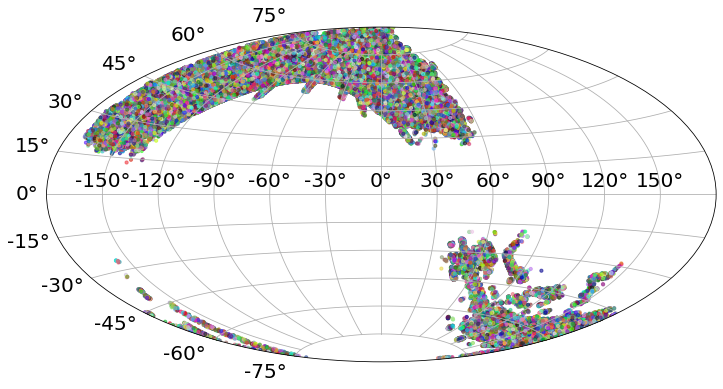

In [9]:
plt.figure(figsize = (12, 8))
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, s=10, c=colors, alpha=0.6, edgecolors=colors, rasterized=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig('plots/skymap.pdf', bbox_inches = 'tight')
plt.show()

In [8]:
total_votes_keys = []
for key in dataframe.keys():
    if 'total-votes' in key:
        total_votes_keys.append(key)

In [13]:
dataframe[total_votes_keys].max(0)

smooth-or-featured_total-votes    303
disk-edge-on_total-votes          239
has-spiral-arms_total-votes       223
bar_total-votes                   223
bulge-size_total-votes            223
how-rounded_total-votes           220
edge-on-bulge_total-votes         155
spiral-winding_total-votes        221
spiral-arm-count_total-votes      221
merging_total-votes               268
dtype: int64

In [14]:
dataframe[total_votes_keys].min(0)

smooth-or-featured_total-votes    1
disk-edge-on_total-votes          0
has-spiral-arms_total-votes       0
bar_total-votes                   0
bulge-size_total-votes            0
how-rounded_total-votes           0
edge-on-bulge_total-votes         0
spiral-winding_total-votes        0
spiral-arm-count_total-votes      0
merging_total-votes               0
dtype: int64

In [17]:
# at least 5 votes for the first question in the galaxy zoo decision tree 
dataframe[dataframe['smooth-or-featured_total-votes'] >= 5].shape

(213116, 127)

### Correct for the locations of the images 

In [2]:
%%capture
!git pull

In [3]:
# dr5_desc = sp.correct_location('gz_decals_volunteers_5', save = True, filename='dr5_votes')

### The data with the votes

In [2]:
dataframe = hp.read_parquet(st.DATA_DIR, 'descriptions/dr5_votes')

In [3]:
labels = sp.generate_labels(dataframe, save=False)

In [4]:
labels.head()

,iauname,png_loc,Smooth,Featured or Disk,Artifact,Round,In Between,Cigar Shaped,Edge On Disk (Yes),Edge On Disk (No),...,Spiral Arms (2),Spiral Arms (3),Spiral Arms (4),Spiral Arms (More Than 4),Spiral Arms (cannot tell),Central Bulge (None),Central Bulge (Small),Central Bulge (Moderate),Central Bulge (Large),Central Bulge (Dominant)
0,J112953.88-000427.4,J112/J112953.88-000427.4.png,1,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0
1,J104325.29+190335.0,J104/J104325.29+190335.0.png,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,J104629.54+115415.1,J104/J104629.54+115415.1.png,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,1,1,0,0
3,J082950.68+125621.8,J082/J082950.68+125621.8.png,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,J122056.00-015022.0,J122/J122056.00-015022.0.png,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0


In [5]:
# labels.to_csv('ml/labels.csv')

# Calculate the weights per class

In [5]:
labels_num = labels.iloc[:,2:]
weights = labels_num.sum(axis=0)
inv_weights = 1/weights
inv_weights_norm = inv_weights/inv_weights.sum()

In [6]:
inv_weights_norm

Smooth                         0.002821
Featured or Disk               0.005690
Artifact                       0.057493
Round                          0.006431
In Between                     0.003816
Cigar Shaped                   0.011399
Edge On Disk (Yes)             0.010705
Edge On Disk (No)              0.003131
Merging (Merger)               0.024418
Merging (Major Disturbance)    0.041934
Merging (Minor Disturbance)    0.017971
Merging (None)                 0.002253
Bulge (Rounded)                0.008159
Bulge (Boxy)                   0.057669
Bulge (None)                   0.023825
No Bar                         0.003642
Weak Bar                       0.014607
Strong Bar                     0.029243
Spiral Arms (Yes)              0.006750
Spiral Arms (No)               0.004657
Spiral Winding (Tight)         0.010099
Spiral Winding (Medium)        0.013962
Spiral Winding (Loose)         0.020519
Spiral Arms (1)                0.055613
Spiral Arms (2)                0.009501


# Split into train, test and validate

In [8]:
train_val_test = sp.split_data(labels, 0.05, 0.15, save=False)

In [9]:
train_val_test['train'].shape

(202628, 36)

In [10]:
train_val_test['validate'].shape

(12665, 36)

In [11]:
train_val_test['test'].shape

(37993, 36)

In [12]:
labels.shape

(253286, 36)

### DataLoader

In [3]:
from src.dataset import DECaLSDataset
from torch.utils.data import Dataset, DataLoader

In [4]:
traindataset = DECaLSDataset(mode = 'train', augment = False, multi_task = True)

The number of training points is 189963


In [10]:
train_loader = DataLoader(dataset=traindataset, batch_size=4, shuffle=True)

In [11]:
dataiter = iter(train_loader)

In [12]:
data = dataiter.next()

In [20]:
sp.find_labels({'task_'+str(i+1): data[1][i][2].tolist() for i in range(10)})

array(['Featured or Disk', 'Edge On Disk (Yes)', 'Bulge (Rounded)',
       'Merging (None)'], dtype='<U27')

# Test Network

In [336]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# our scripts and functions
from src.network import MultiLabelNet, MultiTaskNet
from src.dataset import DECaLSDataset
import settings as st

In [337]:
out_path = './output/'
os.makedirs(out_path, exist_ok=True)

# Set device to CUDA if a CUDA device is available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the dataloader
train_dataset = DECaLSDataset(mode='train', augment=False, multi_task = True)
val_dataset = DECaLSDataset(mode='validate', augment=False, multi_task = True)

train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

The number of training points is 202628
The number of validation points is 12665


In [3]:
# %%capture
# model = MultiLabelNet(backbone="resnet18")
# model.to(device)

In [338]:
LABELS_PER_TASK = {'task_1': 3,
                   'task_2': 3,
                   'task_3': 2,
                   'task_4': 4,
                   'task_5': 3,
                   'task_6': 3,
                   'task_7': 2,
                   'task_8': 3,
                   'task_9': 6,
                   'task_10': 5
                   }

In [339]:
%%capture
model = MultiTaskNet(backbone="resnet18", output_size=LABELS_PER_TASK, resnet_task = True)
model.to(device)

In [6]:
data = next(iter(train_loader))

In [7]:
def criterion(loss, outputs: nn.ModuleDict, labels: dict) -> torch.tensor:
    losses = 0
    for i, key in enumerate(outputs):
        # print(outputs[key])
        # print(labels[key])
        losses += loss(outputs[key], labels[key].float().to(device))
    return losses

In [7]:
outputs = model(data[0].to(device))

In [8]:
outputs = model(data[0].to(device))
labels = data[1]
loss = nn.BCEWithLogitsLoss()
l = criterion(loss, outputs, labels)

# If We Want to Use Shared Representation

- Also implemented a ResNet in 1D. 

In [ ]:
import torch.nn.functional as F

In [26]:
tf_last_layer_chopped = nn.Sequential(*list(model.children())[:-1])

In [32]:
feat = tf_last_layer_chopped(data[0].to(device))

In [34]:
f = feat.to('cpu')

In [69]:
conv1 = nn.Conv1d(1, 1, kernel_size=3, stride=2, padding = (3 - 1)//2)
bn1 = nn.BatchNorm1d(1)
conv2 = nn.Conv1d(1, 1, kernel_size=3, stride=2, padding = (3 - 1)//2)
bn2 = nn.BatchNorm1d(1)

In [99]:
features = f.unsqueeze(1)

In [100]:
out = conv1(features)
out = bn1(out)
out = F.relu(out)
out = conv2(out)
out = bn2(out)

In [101]:
nout = out.shape[-1]
nfeat = features.shape[-1]
left = (1000 - nout) // 2
right = 1000 - left - nout

In [102]:
out = F.pad(input=out, pad=(left, right), mode='constant', value=0)

In [103]:
out += features
out = F.relu(out)

In [107]:
out = conv1(out)
out = bn1(out)
out = F.relu(out)
out = conv2(out)
out = bn2(out)

In [108]:
out.shape

torch.Size([4, 1, 250])

In [138]:
resnet_layer = nn.Sequential(*list(model.children())[:-1])

In [135]:
model_1 = nn.Sequential(*list(model.children())[1]['task_1'].layers[:-1])

In [137]:
# from torchsummary import summary
# summary(model, (1, 224, 224))

# Few Shot Learning

- Copy a few examples (50) of images from the same class in the images/class/ folder. 
- Manually select N examples (high purity samples). 
- Generate the embedding vectors for these images. 
- Calculate the mean of the embedding vectors per class.

Then we have two options:
- Use a nearest neightbour classifier (straightforward)
- Use meta-learning approach 

#### Nearest Neighbour Classifier 
- Normalise the vector properly. 

#### Meta-Learning
- Use this vector to initialise the weights for fine-tuning. 
- Train a classifier with cross-entropy loss (with an entropy regulariser). 

## The main algorithm

In [ ]:
# from src.fewshot import ml_backbone, distance_support_query
# from src.fewshot import ml_feature_extractor
# from src.dataset import FSdataset

In [2]:
## copy the images of the same class to a folder 
#copy_image_fewshot(nobjects = 50, threshold = 0.90)

## make the manual selection of images 

# # get the model 
# model = ml_backbone("ml-models-2022-5-25/resnet_18_multilabel_29.pth")

# # generate the dataloaders

# dataloaders = dict()

# for col in st.FS_CLASSES:
#     fs_subset = FSdataset(support=True, objtype = col, nshot = 10)
#     dataloaders[col] = DataLoader(dataset=fs_subset, batch_size=1, shuffle=False)

# # extract the embeddings
# vectors, vectors_mean = ml_feature_extractor(model, dataloaders, save = True)

## copy the query images in the right folder 
# query, subset = copy_query_images(nshot=10, save = True)

## calculate the distance between the query image and the support set 
# combined = distance_support_query("ml-models-2022-5-25/resnet_18_multilabel_29.pth", nshot=10, save = True)

## Work with Embedding vectors

Note that it is not entirely true that a label can be assigned to a galaxy. The following serves as an illustration only. In practice, the idea is to show the model "similar classes of objects" (for example, 10 images/shots/examples in the Support Set) and the query image/object is then assigned to each class depending on the highest probability. 

### Nearest Neighbour Approach

In [1]:
from src.fewshot import distance_support_query

In [2]:
combined = distance_subset_query("ml-models-2022-5-25/resnet_18_multilabel_29.pth", nshot=10, save = True)

The shape of the subsets embeddings is 4 x 1000


In [4]:
combined.head()

,Objects,True Labels,Predicted Labels
0,J081815.33+162408.9.png,Artifact,Cigar-Shaped
1,J110602.51+305001.0.png,Artifact,Artifact
2,J114717.76+124048.7.png,Artifact,Artifact
3,J093747.60+273412.0.png,Artifact,Merging-Merger
4,J133723.71+243710.8.png,Artifact,Artifact


### Transductive Fine Tuning

NOTE: We have made a copy of the model in the following folder:

/data/phys-zooniverse/phys2286/ml-model-fewshot-ft/

with the filename resnet_18_multilabel_29.pth. 

We will finetune this model and store it under a different name. 

Below is a flow for the algorithm. 

In [1]:
# from src.fewshot import generate_labels_fewshot
# from src.dataset import FewShotFineTuneData
 
## Generate the labels for the support set 
# query, support = generate_labels_fewshot(nshot = 10, save = True)

## The dataloaders for the support and query sets 
# support_dataset = FewShotFineTuneData(support=True, nshot=10)
# support_loader = DataLoader(dataset=support_dataset, batch_size=1, shuffle=True)

# query_dataset = FewShotFineTuneData(support=False, nshot=10)
# query_loader = DataLoader(dataset=query_dataset, batch_size=1, shuffle=True)

In [4]:
import os
import glob
import pandas as pd

In [11]:
import torch
import torch.nn as nn 
from src.network import MultiLabelNet
from src.dataset import DECaLSDataset
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import settings as st

import utils.helpers as hp
import pandas as pd
from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
path = '/data/phys-zooniverse/phys2286/ml-model-fewshot-ft/'
fname = 'resnet_18_multilabel_29.pth'

In [4]:
%%capture
loaded_model = torch.load(path + fname)
model = MultiLabelNet(backbone="resnet18")
model = nn.DataParallel(model, device_ids=[0])
model.load_state_dict(loaded_model)
model.to(device)

In [5]:
backbone = nn.Sequential(list(model.children())[0].backbone)

In [9]:
list(backbone.modules())[-1].out_features

1000

# Embedding Vector

In [1]:
import torch
import torch.nn as nn 
from src.network import MultiLabelNet
from src.dataset import DECaLSDataset
from torch.utils.data import DataLoader
import settings as st

import os
from PIL import Image
import matplotlib.pylab as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
path = '/data/phys-zooniverse/phys2286/Models/ml-models-2022-5-25/'

In [4]:
%%capture
loaded_model = torch.load(path + 'resnet_18_multilabel_29.pth')
model = MultiLabelNet(backbone="resnet18")
model = nn.DataParallel(model, device_ids=[0])
model.load_state_dict(loaded_model)
model.to(device)

In [5]:
# load the model
# loaded_model = torch.load(path + 'resnet_18_multilabel_29.pth')
# model = MultiLabelNet(backbone="resnet18")
# model.to(device)
# model.load_state_dict(loaded_model)
# model.eval()

In [6]:
# tf_last_layer_chopped = nn.Sequential(*list(model.children())[:-1])

In [7]:
tf_last_layer_chopped = nn.Sequential(list(model.children())[0].backbone)

In [8]:
type(tf_last_layer_chopped)

torch.nn.modules.container.Sequential

In [16]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 37993


In [17]:
d1 = test_loader.dataset[0]
d2 = test_loader.dataset[1]
d3 = test_loader.dataset[2]
d4 = test_loader.dataset[3]

In [44]:
o1 = tf_last_layer_chopped(d1[0].view(1,1,224,224).to(device))
o2 = tf_last_layer_chopped(d2[0].view(1,1,224,224).to(device))
o3 = tf_last_layer_chopped(d3[0].view(1,1,224,224).to(device))
o4 = tf_last_layer_chopped(d4[0].view(1,1,224,224).to(device))

In [19]:
d1[1]

tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [20]:
d2[1]

tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
d3[1]

tensor([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [22]:
d4[1]

tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 0])

### Pairwise Distance

In [23]:
pdist = nn.PairwiseDistance(p=2)

In [46]:
pdist(o1, o2)

tensor([1.0826], device='cuda:0', grad_fn=<NormBackward1>)

In [47]:
pdist(o1, o3)

tensor([0.9356], device='cuda:0', grad_fn=<NormBackward1>)

In [48]:
pdist(o2, o3)

tensor([0.2561], device='cuda:0', grad_fn=<NormBackward1>)

In [49]:
pdist(o1, o4)

tensor([0.3248], device='cuda:0', grad_fn=<NormBackward1>)

In [50]:
pdist(o2, o4)

tensor([1.0001], device='cuda:0', grad_fn=<NormBackward1>)

In [51]:
pdist(o3, o4)

tensor([0.8093], device='cuda:0', grad_fn=<NormBackward1>)

### Cosine Similarity

In [52]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [53]:
cos(o1, o2)

tensor([0.9921], device='cuda:0', grad_fn=<DivBackward0>)

In [54]:
cos(o1, o3)

tensor([0.9936], device='cuda:0', grad_fn=<DivBackward0>)

In [55]:
cos(o2, o3)

tensor([0.9996], device='cuda:0', grad_fn=<DivBackward0>)

In [56]:
cos(o1, o4)

tensor([0.9993], device='cuda:0', grad_fn=<DivBackward0>)

In [57]:
cos(o2, o4)

tensor([0.9944], device='cuda:0', grad_fn=<DivBackward0>)

In [58]:
cos(o3, o4)

tensor([0.9961], device='cuda:0', grad_fn=<DivBackward0>)

In [59]:
test_dataset.desc.iloc[0:5]

,iauname,png_loc,Smooth,Featured or Disk,Artifact,Round,In Between,Cigar Shaped,Edge On Disk (Yes),Edge On Disk (No),...,Spiral Arms (2),Spiral Arms (3),Spiral Arms (4),Spiral Arms (More Than 4),Spiral Arms (cannot tell),Central Bulge (None),Central Bulge (Small),Central Bulge (Moderate),Central Bulge (Large),Central Bulge (Dominant)
0,J140750.54+151031.7,J140/J140750.54+151031.7.png,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1,J135718.46+250352.5,J135/J135718.46+250352.5.png,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,J091543.01+300914.0,J091/J091543.01+300914.0.png,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,J081848.46+054220.7,J081/J081848.46+054220.7.png,0,1,0,0,1,0,0,1,...,1,0,0,0,0,1,1,0,1,0
4,J131316.58+093030.6,J131/J131316.58+093030.6.png,0,1,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0


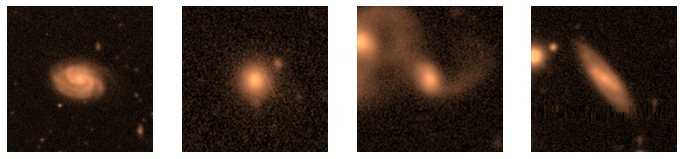

In [61]:
name = 'copper'
plt.figure(figsize = (12, 8))
plt.subplot(141)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
plt.imshow(d1[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(142)
plt.imshow(d2[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(143)
plt.imshow(d3[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(144)
plt.imshow(d4[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')
plt.show()

# Pie Chart

- To repeat this for the entire dataset. 

In [22]:
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt 
import matplotlib as cm
import settings as st
import os 

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 25

In [23]:
dataframe = pd.read_csv('ml/labels.csv')

In [24]:
def calc_percent_task(table: pd.DataFrame, task_number: int = 1):
    
    # sum across columns
    column_sum = table[st.LABELS['task_' + str(task_number)]].sum(0)
    
    # calculate percentage
    percentage = column_sum / column_sum.sum() * 100
    
    return percentage

In [25]:
test = [calc_percent_task(dataframe, i + 1) for i in range(10)]

In [26]:
def plot_pie(index: int = 0, save: bool = False):
    nobject = len(test[index].values)
    colors = iter([plt.cm.Pastel1(k) for k in range(nobject)])
    fig1, ax1 = plt.subplots(figsize=(12,12))
#     fig1.set_figheight(8)
#     fig1.set_figwidth(8)
    patches, texts, autotexts = ax1.pie(test[index].values, labels=test[index].keys(), autopct='%1.1f%%', shadow=False, colors = colors)
    plt.setp(texts, fontsize=fontSize)
    plt.setp(autotexts, fontsize=fontSize)

    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    ax1.axis('equal') 
    
    if save:
        path = 'plots/pie/'
        os.makedirs(path, exist_ok=True)
        plt.savefig(path + 'pie_' + str(index) + '.pdf', bbox_inches = 'tight')
        plt.savefig(path + 'pie_' + str(index) + '.png', bbox_inches = 'tight')
        plt.close()
        
    else:
        plt.show()

In [27]:
# for i in range(10):
#     plot_pie(i, True)

# Metrics for ML and MTL network

In [53]:
from src.postprocess import metric_multitask, metric_multilabel

In [15]:
hl_class_ml, hl_ml = metrics_multilabel('ML_predictions_class', 'test')

Smooth                        : 0.138
Featured or Disk              : 0.143
Artifact                      : 0.029
Round                         : 0.133
In Between                    : 0.200
Cigar Shaped                  : 0.069
Edge On Disk (Yes)            : 0.099
Edge On Disk (No)             : 0.253
Merging (Merger)              : 0.073
Merging (Major Disturbance)   : 0.047
Merging (Minor Disturbance)   : 0.109
Merging (None)                : 0.133
Bulge (Rounded)               : 0.188
Bulge (Boxy)                  : 0.034
Bulge (None)                  : 0.072
No Bar                        : 0.341
Weak Bar                      : 0.137
Strong Bar                    : 0.060
Spiral Arms (Yes)             : 0.131
Spiral Arms (No)              : 0.360
Spiral Winding (Tight)        : 0.149
Spiral Winding (Medium)       : 0.133
Spiral Winding (Loose)        : 0.091
Spiral Arms (1)               : 0.035
Spiral Arms (2)               : 0.146
Spiral Arms (3)               : 0.031
Spiral Arms 

In [54]:
hl_class_mtl, hl_task_mtl = metric_multitask('MTL_predictions_targets_mtl-models-2022-6-14', 'test')

Overall Hamming loss is: 0.153
--------------------------------------------------
Task  1: 0.127
Task  2: 0.295
Task  3: 0.193
Task  4: 0.135
Task  5: 0.106
Task  6: 0.187
Task  7: 0.273
Task  8: 0.127
Task  9: 0.084
Task 10: 0.144
--------------------------------------------------
Smooth                        : 0.154
Featured or Disk              : 0.145
Artifact                      : 0.081
Round                         : 0.201
In Between                    : 0.513
Cigar Shaped                  : 0.170
Edge On Disk (Yes)            : 0.113
Edge On Disk (No)             : 0.273
Merging (Merger)              : 0.131
Merging (Major Disturbance)   : 0.060
Merging (Minor Disturbance)   : 0.180
Merging (None)                : 0.172
Bulge (Rounded)               : 0.194
Bulge (Boxy)                  : 0.038
Bulge (None)                  : 0.085
No Bar                        : 0.360
Weak Bar                      : 0.138
Strong Bar                    : 0.061
Spiral Arms (Yes)             : 0

# Predictions for ML

In [4]:
import torch
import torch.nn as nn 
from src.network import MultiLabelNet
from src.dataset import DECaLSDataset
from torch.utils.data import DataLoader
import settings as st
import numpy as np 

import utils.helpers as hp
import os
from PIL import Image
import matplotlib.pylab as plt

In [2]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 37993


In [5]:
pred = hp.load_csv('results', 'ML_predictions_class')
test = hp.load_csv('ml', 'test')

In [68]:
def compare_labels(dataloader, idx, pred, savefig: bool = False):
    
    # the labels
    columns = np.array(dataloader.dataset.desc.columns[2:])
    
    # the filename
    filename = dataloader.dataset.desc.iauname.iloc[idx]
    
    # the data
    data = dataloader.dataset[idx]
    
    # the predicted labels 
    labels_pred = columns[pred.iloc[idx].values == 1]
    
    # the ground truth
    labels_test = columns[data[1] == 1]
    
    name = 'copper'
    plt.figure(figsize = (4,4))
    plt.imshow(data[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
    plt.axis('off')
    
    if savefig:
        os.makedirs('plots', exist_ok=True)
        plt.savefig(f'plots/{filename}.pdf', bbox_inches = 'tight')
    plt.show()
    
    print('Predictions')
    print('-'*11)
    for i, element in enumerate(labels_pred):
        print(f'Tag {i:2d}: {element}')
    
    print()
    print('Volunteers')
    print('-'*10)
    for i, element in enumerate(labels_test):
        print(f'Tag {i:2d}: {element}')
    
    return labels_test, labels_pred

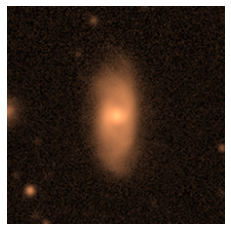

Predictions
-----------
Tag  0: Featured or Disk
Tag  1: In Between
Tag  2: Edge On Disk (No)
Tag  3: Merging (None)
Tag  4: No Bar
Tag  5: Spiral Arms (Yes)
Tag  6: Spiral Winding (Medium)
Tag  7: Spiral Arms (2)
Tag  8: Central Bulge (Moderate)

Volunteers
----------
Tag  0: Featured or Disk
Tag  1: In Between
Tag  2: Edge On Disk (No)
Tag  3: Merging (None)
Tag  4: Bulge (Rounded)
Tag  5: Weak Bar
Tag  6: Spiral Arms (Yes)
Tag  7: Spiral Winding (Medium)
Tag  8: Spiral Arms (2)
Tag  9: Central Bulge (Moderate)


In [107]:
labels_test, labels_pred = compare_labels(test_loader, 1300, pred, savefig = True)

# Build the Tree

In [1]:
import settings as st 
import utils.helpers as hp
import src.processing as sp
import sklearn.metrics as sm
import pandas as pd
import numpy as np 

In [8]:
date = '2022-6-14'

In [2]:
preds = hp.load_pickle('results', 'MTL_predictions_mtl-models-'+date)
test = hp.load_csv('ml', 'test')

In [3]:
def labels_test(test: pd.DataFrame, index: int = 0):
    
    # the first two column names are the name and png locations
    labels = test.iloc[index, 2:]
    
    label_dict = dict()
    for i in range(st.NUM_TASKS):
        task = labels[st.LABELS['task_' + str(i + 1)]].values.astype(int)
        label_dict['task_' + str(i + 1)] = task
        
    return label_dict

In [4]:
ntest = test.shape[0]
tree_pred = list()
tree_test = list()

for idx in range(ntest):
    
    # re-write the test point in a dictionary (label per task)
    test_point = labels_test(test, idx)
          
    # find the labels (ground truths and test point)
    pred_labels = sp.find_labels(preds[idx])
    test_labels = sp.find_labels(test_point)
    
    # record the trees
    tree_pred.append(pred_labels)
    tree_test.append(test_labels)

In [5]:
tree_pred_df = pd.concat(tree_pred)
tree_test_df = pd.concat(tree_test)

In [6]:
tree_pred_df.reset_index(drop=True, inplace=True)
tree_test_df.reset_index(drop=True, inplace=True)

Save the outputs

In [9]:
tree_pred_df.to_csv('results/tree_pred-'+date+'.csv', index=False)
tree_test_df.to_csv('results/tree_test-'+date+'.csv', index=False)

# Visualise Image and Tree

In [30]:
import pandas as pd 
import sklearn.metrics as sm
from src.dataset import DECaLSDataset
from torch.utils.data import DataLoader
import matplotlib.pylab as plt
import os

In [19]:
date = '2022-6-14'
tree_pred_df = pd.read_csv('results/tree_pred-'+date+'.csv')
tree_test_df = pd.read_csv('results/tree_test-'+date+'.csv')

In [20]:
idxs = [6510, 6511, 6512, 6513]
# idxs = [6, 7, 8, 9]

In [21]:
tree_pred_df.iloc[idxs]

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
6510,['Smooth'],['Round'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
6511,['Smooth'],['Cigar Shaped'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
6512,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (None)'],NaN,['No Bar'],['Spiral Arms (No)'],NaN,NaN,['Central Bulge (Moderate)']
6513,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (None)'],NaN,['No Bar'],['Spiral Arms (Yes)'],['Spiral Winding (Tight)'],['Spiral Arms (3)'],['Central Bulge (Small)']


In [22]:
tree_test_df.iloc[idxs]

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
6510,['Smooth'],"['Round', 'In Between']",NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
6511,['Featured or Disk'],NaN,['Edge On Disk (Yes)'],['Merging (None)'],['Bulge (Rounded)'],NaN,NaN,NaN,NaN,NaN
6512,['Smooth'],['In Between'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
6513,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (None)'],NaN,['No Bar'],['Spiral Arms (Yes)'],"['Spiral Winding (Tight)', 'Spiral Winding (Me...",['Spiral Arms (cannot tell)'],['Central Bulge (Small)']


In [23]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 37993


In [24]:
d1 = test_loader.dataset[idxs[0]]
d2 = test_loader.dataset[idxs[1]]
d3 = test_loader.dataset[idxs[2]]
d4 = test_loader.dataset[idxs[3]]

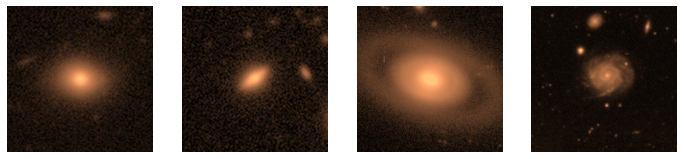

In [27]:
name = 'copper'
plt.figure(figsize = (12, 8))
plt.subplot(141)
plt.imshow(d1[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(142)
plt.imshow(d2[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(143)
plt.imshow(d3[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(144)
plt.imshow(d4[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')
plt.show()

In [31]:
def compare_tree(dataloader, idx, pred, test, savefig: bool = False):
    
    # the labels
    columns = np.array(dataloader.dataset.desc.columns[2:])
    
    # the filename
    filename = dataloader.dataset.desc.iauname.iloc[idx]
    
    # the data
    data = dataloader.dataset[idx]
    
    # the predicted labels 
    labels_pred = pred.iloc[idx]
    labels_pred = pd.DataFrame(labels_pred[~labels_pred.isna()])
    
    # the ground truth
    labels_test = test.iloc[idx]
    labels_test = pd.DataFrame(labels_test[~labels_test.isna()])
    
    name = 'copper'
    plt.figure(figsize = (4,4))
    plt.imshow(data[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
    plt.axis('off')
    
    if savefig:
        os.makedirs('plots', exist_ok=True)
        plt.savefig(f'plots/{filename}.pdf', bbox_inches = 'tight')
    plt.show()
    
    print('Predictions')
    print('-'*11)
    print(labels_pred)
    print()
    print('Volunteers')
    print('-'*10)
    print(labels_test)
    
    return labels_pred, labels_test

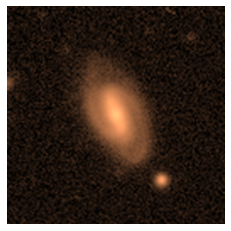

Predictions
-----------
                                8501
task_1          ['Featured or Disk']
task_3         ['Edge On Disk (No)']
task_4            ['Merging (None)']
task_6                ['Strong Bar']
task_7         ['Spiral Arms (Yes)']
task_8   ['Spiral Winding (Medium)']
task_9           ['Spiral Arms (2)']
task_10    ['Central Bulge (Small)']

Volunteers
----------
                                 8501
task_1           ['Featured or Disk']
task_3          ['Edge On Disk (No)']
task_4           ['Merging (Merger)']
task_6                 ['Strong Bar']
task_7          ['Spiral Arms (Yes)']
task_8    ['Spiral Winding (Medium)']
task_9            ['Spiral Arms (2)']
task_10  ['Central Bulge (Moderate)']


In [32]:
labels_pred, labels_test = compare_tree(test_loader, 8501, tree_pred_df, tree_test_df, savefig=True)

### Count number of labels per task in the test set

In [33]:
def count_element(dataframe, task):
    
    ntest = dataframe.shape[0]
    
    record = []
    
    for i in range(ntest):
        
        element = dataframe[task].values[i]
        
        if not pd.isna(element):
            count = len(eval(element))
            
        else:
            count = 0 
            
        record.append(count)
        
    return pd.DataFrame(record, columns = [task])

In [34]:
tree_test_counts = []

for i in range(10):
    tree_test_counts.append(count_element(tree_test_df, 'task_'+str(i+1)))

In [35]:
tree_test_counts = pd.concat(tree_test_counts, axis = 1)

In [36]:
tree_test_counts.head()

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,1,0,1,1,0,1,1,1,1,1
1,1,1,0,1,0,0,0,0,0,0
2,1,0,1,1,0,1,1,0,0,1
3,1,0,1,1,0,1,1,3,1,3
4,1,0,1,1,0,1,1,0,0,1


Select rows which has only one element

In [37]:
subset_test = tree_test_df[(tree_test_counts <= 1).all(1)]
subset_pred = tree_pred_df[(tree_test_counts <= 1).all(1)]

subset_test.reset_index(drop=True, inplace=True)
subset_pred.reset_index(drop=True, inplace=True)

In [38]:
print(f'Number of examples where we have unique labels is {subset_test.shape[0]}')

Number of examples where we have unique labels is 28838


In [39]:
subset_test.head()

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (None)'],NaN,['No Bar'],['Spiral Arms (Yes)'],['Spiral Winding (Tight)'],['Spiral Arms (3)'],['Central Bulge (Small)']
1,['Smooth'],['Round'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
2,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (Merger)'],NaN,['No Bar'],['Spiral Arms (No)'],NaN,NaN,['Central Bulge (Dominant)']
3,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (None)'],NaN,['No Bar'],['Spiral Arms (No)'],NaN,NaN,['Central Bulge (Small)']
4,['Smooth'],['In Between'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN


### Metrics for Multi-Task

Assign a specific label to the different labels

We are essentially removing the list and assigning only the label.

In [40]:
def process_element(dataframe):
    
    ntest = dataframe.shape[0]
    
    record = []
    
    for t in range(10):
        task = 'task_'+str(t+1)
        for i in range(ntest):

            element = dataframe[task].values[i]

            if not pd.isna(element):
                dataframe[task].iloc[i] = eval(element)[0]
        
    return dataframe

In [41]:
df_pred = subset_pred.copy()
df_test = subset_test.copy()

In [42]:
df_test.head()

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (None)'],NaN,['No Bar'],['Spiral Arms (Yes)'],['Spiral Winding (Tight)'],['Spiral Arms (3)'],['Central Bulge (Small)']
1,['Smooth'],['Round'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
2,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (Merger)'],NaN,['No Bar'],['Spiral Arms (No)'],NaN,NaN,['Central Bulge (Dominant)']
3,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (None)'],NaN,['No Bar'],['Spiral Arms (No)'],NaN,NaN,['Central Bulge (Small)']
4,['Smooth'],['In Between'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# process the dataframe
df_processed_pred = process_element(df_pred)
df_processed_test = process_element(df_test)

In [44]:
df_processed_test.head()

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,Featured or Disk,NaN,Edge On Disk (No),Merging (None),NaN,No Bar,Spiral Arms (Yes),Spiral Winding (Tight),Spiral Arms (3),Central Bulge (Small)
1,Smooth,Round,NaN,Merging (None),NaN,NaN,NaN,NaN,NaN,NaN
2,Featured or Disk,NaN,Edge On Disk (No),Merging (Merger),NaN,No Bar,Spiral Arms (No),NaN,NaN,Central Bulge (Dominant)
3,Featured or Disk,NaN,Edge On Disk (No),Merging (None),NaN,No Bar,Spiral Arms (No),NaN,NaN,Central Bulge (Small)
4,Smooth,In Between,NaN,Merging (None),NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
def overall_mapping(df_test, df_pred):
    
    mapping = {}
    
    count = 1
    
    for t in range(10):
        for l in st.LABELS['task_'+str(t+1)]:
            mapping[l] = count
            count += 1
            
    df_pred_mapped = df_pred.applymap(lambda s: mapping.get(s) if s in mapping else s) 
    df_test_mapped = df_test.applymap(lambda s: mapping.get(s) if s in mapping else s)
    
    df_pred_mapped = df_pred_mapped.fillna(0)
    df_test_mapped = df_test_mapped.fillna(0)

    df_pred_mapped = df_pred_mapped.astype(int)
    df_test_mapped = df_test_mapped.astype(int)
    
    return df_test_mapped, df_pred_mapped

In [46]:
def hamming_per_task(df_test, df_pred, task):
    
    # build the mapping 
    mapping = {st.LABELS[task][i]: i+1 for i in range(len(st.LABELS[task]))}
       
    df_pred_mapped = df_pred[task].map(mapping)
    df_test_mapped = df_test[task].map(mapping)
    
    df_pred_mapped = df_pred_mapped.fillna(0)
    df_test_mapped = df_test_mapped.fillna(0)
    
    df_pred_mapped = df_pred_mapped.astype(int)
    df_test_mapped = df_test_mapped.astype(int)
    
    ham_loss = sm.hamming_loss(df_test_mapped, df_pred_mapped)
    
    return ham_loss

In [47]:
import settings as st

In [48]:
for i in range(10):
    hl = hamming_per_task(df_processed_test, df_processed_pred, 'task_'+str(i+1))
    print(f'Task {i+1}: {hl:.3f}')
    print('-'*100)

Task 1: 0.150
----------------------------------------------------------------------------------------------------
Task 2: 0.304
----------------------------------------------------------------------------------------------------
Task 3: 0.115
----------------------------------------------------------------------------------------------------
Task 4: 0.231
----------------------------------------------------------------------------------------------------
Task 5: 0.055
----------------------------------------------------------------------------------------------------
Task 6: 0.113
----------------------------------------------------------------------------------------------------
Task 7: 0.092
----------------------------------------------------------------------------------------------------
Task 8: 0.103
----------------------------------------------------------------------------------------------------
Task 9: 0.113
------------------------------------------------------------------

In [49]:
df1, df2 = overall_mapping(df_processed_test, df_processed_pred)

In [50]:
def metrics(df_test, df_pred):
    
    for i in range(10):
        task = 'task_'+str(i+1)
        
        acc = sm.accuracy_score(df_test[task], df_pred[task], normalize=True, sample_weight=None)
        ham = sm.hamming_loss(df_test[task], df_pred[task])
        pre = sm.precision_score(df_test[task], df_pred[task], average = "micro")
        rec = sm.recall_score(df_test[task], df_pred[task], average = "micro")
        f_1 = sm.f1_score(df_test[task], df_pred[task], average = "micro")
        
        print(f'Accuracy Score for Task {i+1}  : {acc:.3f}')
        print(f'Hamming Score for Task {i+1}   : {ham:.3f}')
        print(f'Precision Score for Task {i+1} : {pre:.3f}')
        print(f'Recall Score for Task {i+1}    : {rec:.3f}')
        print(f'F1 Score for Task {i+1}        : {f_1:.3f}')
        print('-'*50)

In [51]:
metrics(df1, df2)

Accuracy Score for Task 1  : 0.850
Hamming Score for Task 1   : 0.150
Precision Score for Task 1 : 0.850
Recall Score for Task 1    : 0.850
F1 Score for Task 1        : 0.850
--------------------------------------------------
Accuracy Score for Task 2  : 0.696
Hamming Score for Task 2   : 0.304
Precision Score for Task 2 : 0.696
Recall Score for Task 2    : 0.696
F1 Score for Task 2        : 0.696
--------------------------------------------------
Accuracy Score for Task 3  : 0.885
Hamming Score for Task 3   : 0.115
Precision Score for Task 3 : 0.885
Recall Score for Task 3    : 0.885
F1 Score for Task 3        : 0.885
--------------------------------------------------
Accuracy Score for Task 4  : 0.769
Hamming Score for Task 4   : 0.231
Precision Score for Task 4 : 0.769
Recall Score for Task 4    : 0.769
F1 Score for Task 4        : 0.769
--------------------------------------------------
Accuracy Score for Task 5  : 0.945
Hamming Score for Task 5   : 0.055
Precision Score for Task 5

# Number of Similar Trees

In [43]:
x = df1 == df2

In [44]:
frac = sum(x.all(1) * 1) / x.shape[0] * 100

print(f'Percentage of similar trees is {frac:.2f}')

Percentage of similar trees is 34.61


# Representations

In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# our scripts and functions
from src.network import MultiLabelNet, MultiTaskNet
from src.dataset import DECaLSDataset
import settings as st

import matplotlib.pylab as plt 
import matplotlib as cm

# plt.rc('text', usetex=True)
# plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
# figSize  = (12, 8)
# fontSize = 25

In [2]:
date = '2022-6-14'

In [3]:
# we can use these trees to choose an object we want to investigate
# tree_pred_df = pd.read_csv('results/tree_pred-'+date+'.csv')
# tree_test_df = pd.read_csv('results/tree_test-'+date+'.csv')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
path = '/data/phys-zooniverse/phys2286/Models/'

In [6]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 37993


In [17]:
ntest = len(test_loader.dataset)

In [7]:
# we are choosing one particular object
reference_id = 412
data = test_loader.dataset[reference_id]

### Using Multi-Task Network

In [8]:
%%capture
loaded_model = torch.load(path + f'mtl-models-{date}/resnet_18_multitask_29.pth')
model = MultiTaskNet(backbone="resnet18", output_size=st.LABELS_PER_TASK, resnet_task=True)
model = nn.DataParallel(model, device_ids=[0])
model.load_state_dict(loaded_model)
model.to(device)

In [ ]:
# the backbone for multi-task learning
backbone = nn.Sequential(*list(model.backbone.children()))

# the different decoders
decoders = model.decoders #list(model.children())[1]

In [9]:
def embeddings_mtl(backbone, decoders, data):
    
    # backbone = nn.Sequential(*list(model.children())[:-1])
    # model = list(model.children())[0]
    
    shared = backbone(data[0].view(1, 1, 224, 224).to(device))
    
    dec = {}
    
    for k in range(10):
        task = 'task_' + str(k+1)
        model_task = nn.Sequential(*list(decoders[task].children())[:-1])
        dec[task] = model_task(shared.view(1, 1, 1000)).view(-1)
        
    return shared.view(-1), dec

In [10]:
fixed = embeddings_mtl(model, data)

In [11]:
pdist = nn.PairwiseDistance(p=2)

In [18]:
record = []

for i in range(ntest):
    
    toAppend = {}
    
    ith_data = test_loader.dataset[i]
    
    shared, tasks = embeddings_mtl(model, ith_data)
    
    dist_shared = pdist(fixed[0], shared)
    
    toAppend['shared'] = dist_shared.item()
    
    for m in range(10):
        t = 'task_' + str(m + 1)
        dist_task = pdist(fixed[1][t], tasks[t])
        
        toAppend[t]= dist_task.item()

    record.append(toAppend)

In [21]:
distances_df = pd.DataFrame(record)

In [22]:
distances_df.to_csv(f'results/distances_mtl_{reference_id}.csv')

### Load Distances

In [44]:
# distances_df = pd.read_csv(f'results/distances_mtl_{reference_id}.csv').iloc[:,1:]

In [23]:
nobjects = 35

idxs = list(distances_df.sort_values(by=['shared']).head(nobjects).index)
# idxs = list(distances_df.sort_values(by=['task_1']).head(nobjects).index)

In [24]:
# plt.imshow(test_loader.dataset[412][0].permute(1, 2, 0), cmap=plt.get_cmap(name))
# plt.axis('off')
# plt.show()

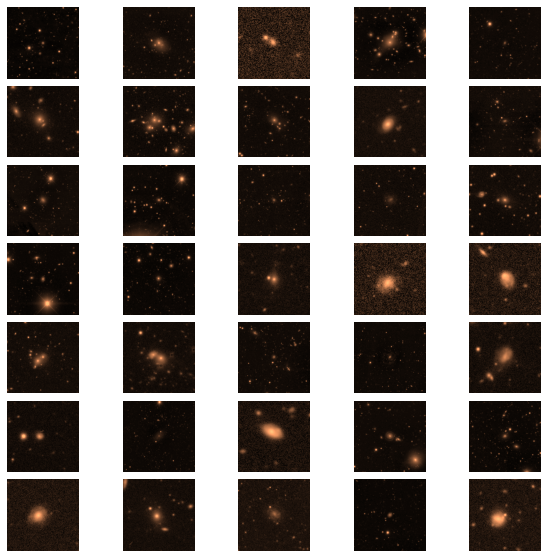

In [25]:
name = 'copper'
plt.figure(figsize = (10, 10))
for i in range(nobjects):
    plt.subplot(7, 5, i+1)
    plt.imshow(test_loader.dataset[idxs[i]][0].permute(1, 2, 0), cmap=plt.get_cmap(name))
    plt.axis('off')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
# plt.savefig('plots/neighbours_artifacts.pdf', bbox_inches = 'tight')
plt.show()

## Using Multi-Label Network

In [26]:
import torch
import torch.nn as nn 
from src.network import MultiLabelNet
from src.dataset import DECaLSDataset
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F
import settings as st

import utils.helpers as hp
import pandas as pd
from PIL import Image

In [32]:
path = '/data/phys-zooniverse/phys2286/Models/'
fname = 'ml-models-2022-5-25/resnet_18_multilabel_29.pth'

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 37993


In [30]:
ntest = len(test_loader.dataset)

In [33]:
%%capture
loaded_model = torch.load(path + fname)
model = MultiLabelNet(backbone="resnet18")
model = nn.DataParallel(model, device_ids=[0])
model.load_state_dict(loaded_model)
model.to(device)

In [34]:
backbone = nn.Sequential(list(model.children())[0].backbone)

In [35]:
def embeddings_ml(backbone, data):
    
    embeddings = backbone(data[0].view(1, 1, 224, 224).to(device)).view(-1)
    
    return embeddings

In [64]:
# we are choosing one particular object
reference_id = 2611
data = test_loader.dataset[reference_id]

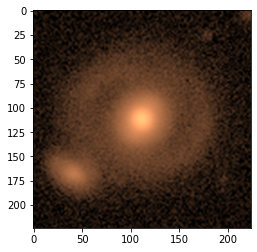

In [65]:
plt.imshow(data[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.show()

In [79]:
fixed = embeddings_ml(backbone, data)
fixed_norm = F.normalize(fixed.view(1,-1))

In [67]:
pdist = nn.PairwiseDistance(p=2)

In [83]:
record = []

for i in range(ntest):
    
    embeddings = embeddings_ml(backbone, test_loader.dataset[i])
    # distance = pdist(fixed, embeddings)
    
    embeddings_norm = F.normalize(embeddings.view(1,-1))
    distance = torch.cdist(fixed_norm, embeddings_norm, p=1)
    
    record.append(distance.item())

In [84]:
distance_ml = pd.DataFrame(record, columns= ['Distance'])

In [85]:
distance_ml.to_csv(f'results/distances_ml_{reference_id}.csv')

### Visualise Nearest Objects

In [86]:
nobjects = 35

idxs = list(distance_ml.sort_values(by=['Distance']).head(nobjects).index)

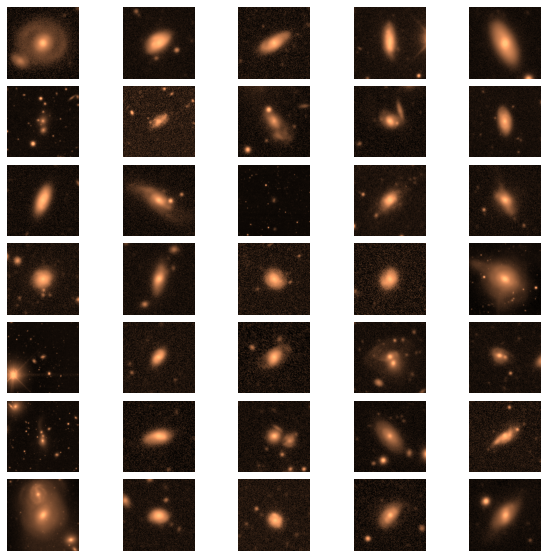

In [87]:
name = 'copper'
plt.figure(figsize = (10, 10))
for i in range(nobjects):
    plt.subplot(nobjects//5, 5, i+1)
    plt.imshow(test_loader.dataset[idxs[i]][0].permute(1, 2, 0), cmap=plt.get_cmap(name))
    plt.axis('off')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
# plt.savefig('plots/neighbours_artifacts.pdf', bbox_inches = 'tight')
plt.show()